# <font color="darkblue"> Projeto 02 - Kaggle Titanic</font>

**Equipe**:
- Pedro Vitor Vilar Pitzer Cleis - 20241008284
- Ana Carla Sergina Nonato de Lima - 20241019493 

### História:
O desastre do Titanic não só marcou a história, mas também deixou dados valiosos que podemos usar hoje para entender quem tinha maior chance de sobreviver. Nosso objetivo é usar aprendizado de máquina para responder: 'Quem teria mais probabilidade de sobreviver ao Titanic?'

### Contexto:
Este projeto utiliza aprendizado supervisionado para construir uma Rede Neural Perceptron de Múltiplas Camadas (MLP).

### Objetivo:
O objetivo final é treinar um modelo preditivo baseado em características dos passageiros, como idade, sexo e classe.

---
---

## Adicionar bibliotecas e arquivos

Adicionar bibliotecas:

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras import models
from keras.layers import Dense, Dropout, Input
import cf_matrix as cfm

Adiciona arquivos:

In [60]:
data_path = "data/"
training = pd.read_csv(data_path + "train.csv")
test = pd.read_csv(data_path + "test.csv")

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.nan
all_data = pd.concat([training, test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

## Informações sobre os dados de treinamento

Informações sobre o dataset, como o tipo de cada coluna quantos valores não nulos:

In [61]:
training.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


Vemos então que grande parte das colunas estão com os dados completos, as colunas que não têm tantos dados são:
- Age
- Cabin

E *Embarked* apenas 2 estão sem dados

---

Informações estatísticas sobre as colunas numéricas:

In [62]:
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


Podemos ter uma visão melhor de como os dados estão distribuídos. Temos dados como a média, o desvio padrão e outros dados estatísticos.

---

Nos indica quais são as colunas que contêm dados int ou float:

In [63]:
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

Podemos então separar colunas que contêm dados numéricos e categóricos:

In [64]:
df_num = training[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = training[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

Com as colunas numéricas podemos trabalhar com histogramas e as colunas categóricas podemos trabalhar com contagem de valor

---

Podemos ver então os histogramas de todas as colunas numéricas:

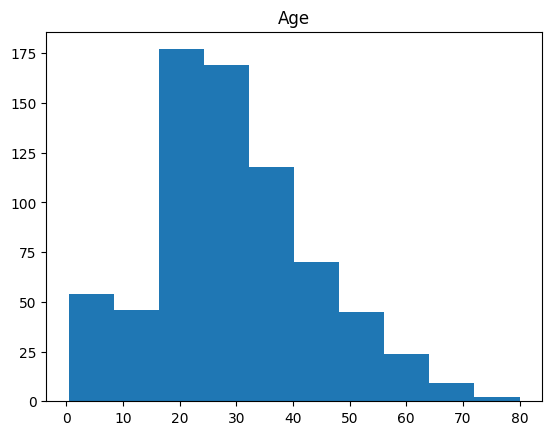

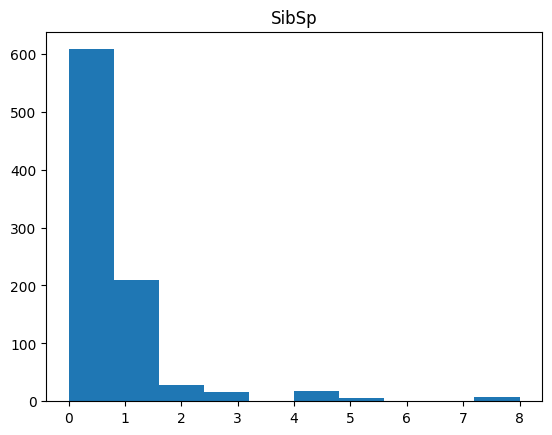

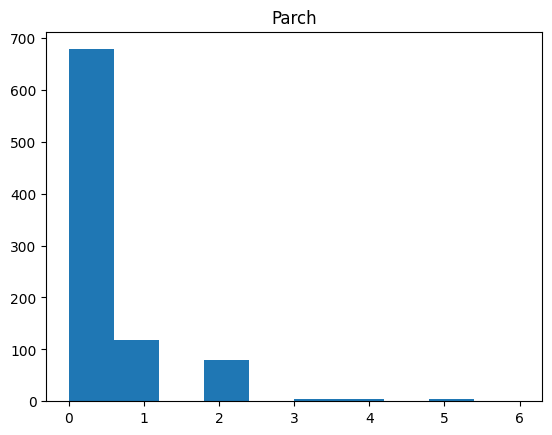

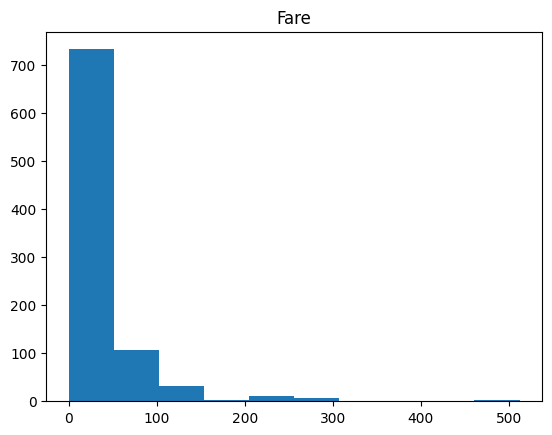

In [65]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

Vemos que *Age* segue uma distribuição próxima da normal, por enquanto que as demais não seguem. Sendo interessante normalizar estas outras (*SibSp*, *Parch*, *Fare*).

---

Podemos então ver as correlações entre as colunas numéricas:

<Axes: >

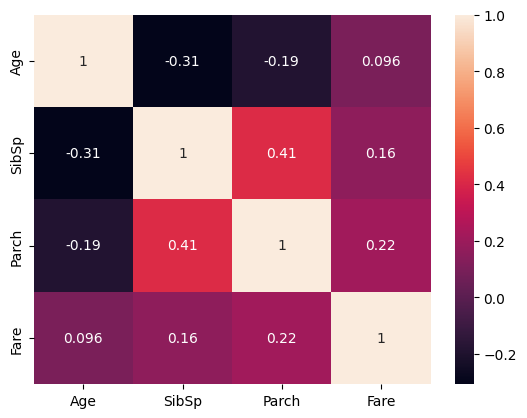

In [66]:
sns.heatmap(df_num.corr(), annot=True)

Podemos então evitar utilizar 2 colunas que estão extremamente correlacionadas, o que não ocorre aqui.

---

Podemos ver então como o índice de sobrevivência se relaciona entre esses grupos:

In [67]:
pd.pivot_table(training, index='Survived', values=['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


Se eles sobreviveram, podemos ver qual a média da idade, valor da passagem e tamanho da família.

Podemos ver que pessoas mais jovens, que pagaram mais, que os pais embarcaram no Titanic e que não têm irmãos no Titanic têm uma chance maior de sobreviver.

---

Fazemos então gráficos das colunas categóricas:

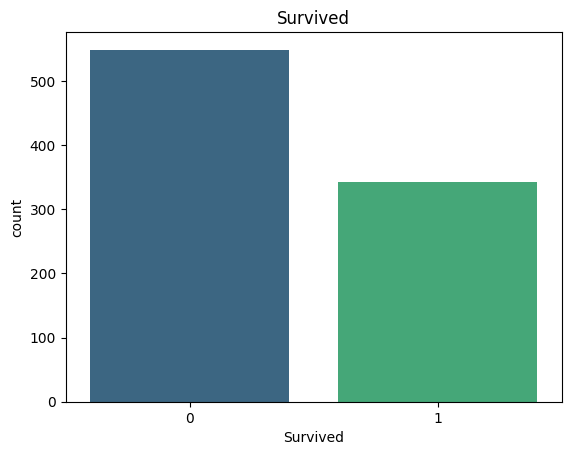

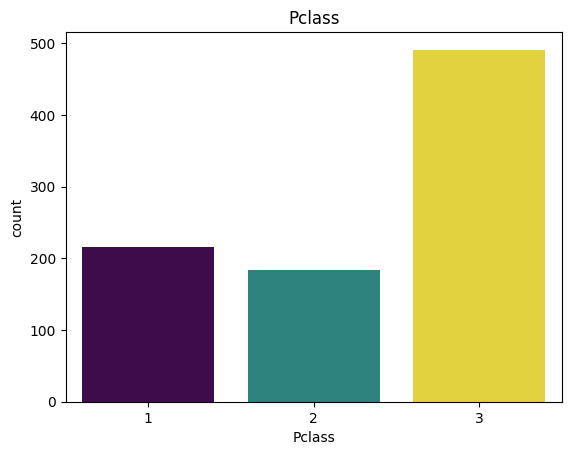

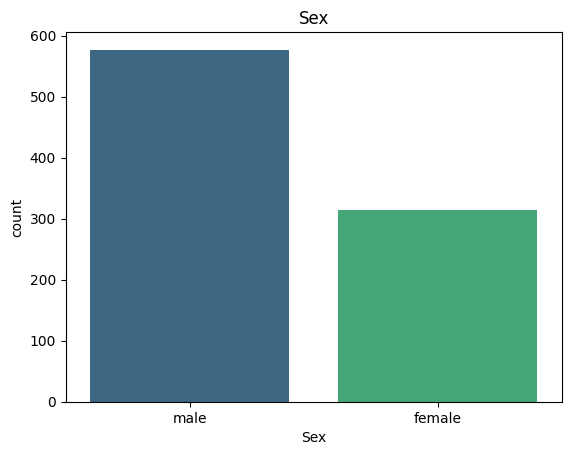

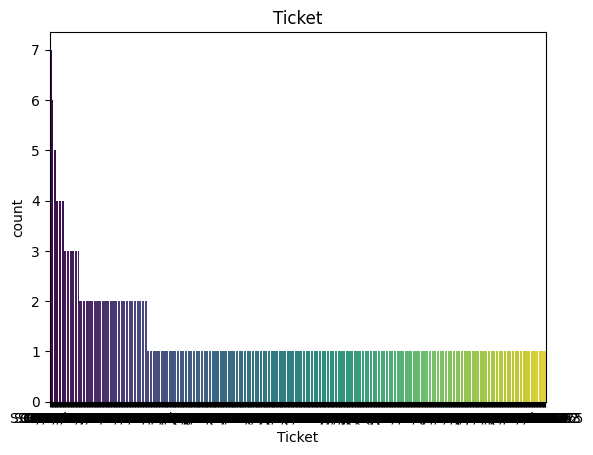

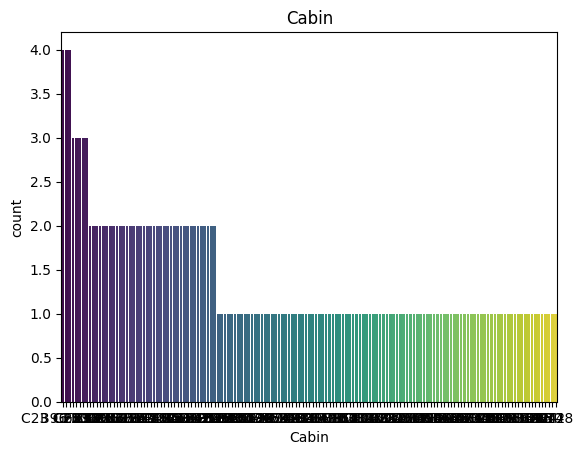

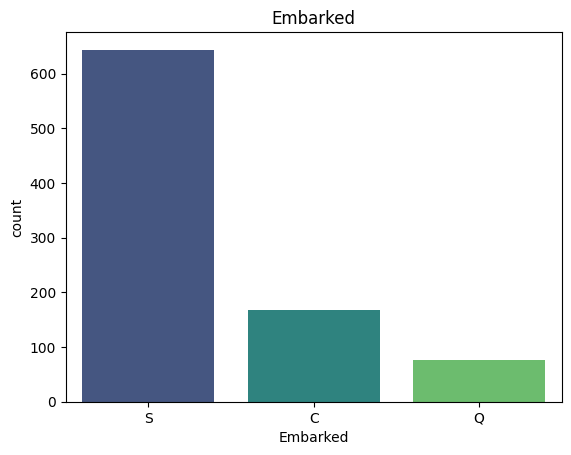

In [68]:
for i in df_cat.columns:
    sns.barplot(x=df_cat[i].value_counts().index, y=df_cat[i].value_counts(), hue=df_cat[i].value_counts().index, palette="viridis", dodge=False, legend=False).set_title(i)
    plt.show()

Após termos uma visão gráfica das colunas categóricas, podemos então fazer uma análise da relação entre estas colunas e a sobrevivência dos passagerios:

In [69]:
print(pd.pivot_table(training, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


Podemos ver então que proporcionalmente mais pessoas com estas características sobreviveram:
- Primeira classe
- Sexo feminino

Não podemos ter uma relação muito forte sobre o porto de embarque,  no máximo podemos dizer que quem embarcou em Cherbourg teria uma chance maior de sobreviver.

## *Feature Engineering*

Vemos que a quantidade de dados disponível para o treinamento é pequena (891) para a quantidade de colunas.

Devemos então trabalhar em quais características podemos utilizar no treinamento, diminuindo a quantidade de colunas e trabalhando os dados que já temos.

---

Olhando os dados da cabine, vemos que a coluna *Cabin* é composta de uma letra e o número da cabine. Utilizando expressões regulares podemos separar essa coluna nessas duas categorias.

Uma primeira informação é saber quantas pessoas possuiam mais de uma cabine:

In [70]:
df_cat.Cabin
training['cabin_multiple'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
training['cabin_multiple'].value_counts()

cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

Vemos que a grande maioria não possuía mais de uma cabine.
Podemos ver então qual o índice de sobrevivência para cada uma dessas categorias:

In [71]:
pd.pivot_table(training, index='Survived', columns='cabin_multiple', values='Ticket', aggfunc='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


Podemos também pesquisar a relação de sobrevivência com a letra da cabine:

Observação: temos a letra **n** para pessoas sem a cabine registrada.

In [72]:
training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])
print(training.cabin_adv.value_counts())
pd.pivot_table(training,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')


cabin_adv
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


Podemos ver que é possível utilizar os dados da cabine como uma *feature*, já que a maioria dos que têm esse dado e não estão na cabine A sobreviveram.

---

A próxima coluna que estudaremos é a *Ticket*.
Quase todo número do ticket é único ou próximo de único, mas alguns possuem apenas números e outros possuem letras.
Provavelmente estas letras estão relacionadas ao porto em que eles embarcaram.

In [73]:
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
training['numeric_ticket'].value_counts()

numeric_ticket
1    661
0    230
Name: count, dtype: int64

Temos 1 para os tickets apenas de núemros e 0 para os que têm letras.

Vemos então quais são os textos que têm nos tickets:

In [74]:
pd.set_option("display.max_rows", None)
training['ticket_letters'].value_counts()

ticket_letters
0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
c              5
fcc            5
pp             3
wep            3
sopp           3
ppp            2
sotono2        2
scah           2
swpp           2
sp             1
sca4           1
scow           1
fa             1
sop            1
sc             1
scahbasle      1
as             1
fc             1
casoton        1
Name: count, dtype: int64

Como a quantidade de textos possíveis no ticket é grande, não faremos uma análise mais aprofundada em cada texto.

Podemos então ver se ter letras ou não no ticket têm algum impacto na sobrevivência:

In [75]:
pd.pivot_table(training,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


Podemos ver então que não há, já que a correlação é extremamente parecida.

---

A próxima coluna que pesquisaremos é a **Name**, podemos ter a possibilidade de mais informações além de apenas o sexo do passageiro.

In [76]:
training.Name.head(50)
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
training['name_title'].value_counts()

name_title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

Podemos ver que há uma pequena variação dos títulos.

## Pré-processamento dos dados

Alguns passos no pré-processamento:

- Como o sistema não lida bem com dados nulos, faremos *drop* dos valores nulos de *Embarked*, já que são apenas 2
- Incluir apenas os dados que relevantes (já que temos poucos dados)
  - Utilizaremos: *Pclass*, *Sex*, *Age*, *SisSp*, *Parch*, *Fare*, *Embarked*, *cabin_adv*, *cabin_multiplier*, *numeric_ticket* e *name_title*
- Transformar todos os dados categóricos em colunas
- Imputar dados com média para *Age* e mediana para *Fare*
  - Utilizamos média para *Age* já que a distribuição lembra a normal e mediana para *Fare* já que não a distribuição não parece a normal
- Normalizar *Fare* usando logaritmo para parecer uma distribuição normal
- Escalonar dados 0-1 com escalonador padrão

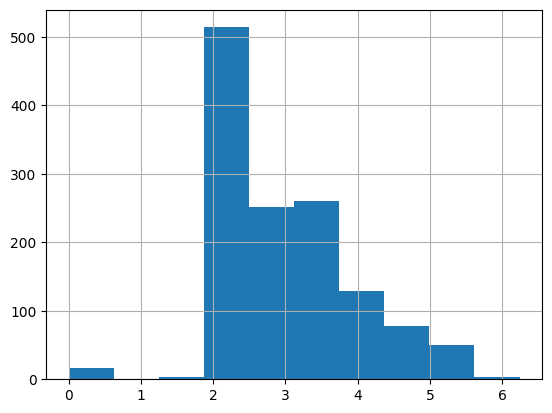

In [77]:
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

all_data.Age = all_data.Age.fillna(training.Age.mean())
all_data.Fare = all_data.Fare.fillna(training.Fare.median())

all_data.dropna(subset=['Embarked'], inplace = True)

all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

all_data.Pclass = all_data.Pclass.astype(str)

all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple', 'name_title','train_test']])

X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)

Escalonar os dados e separá-los entre treino e teste:

In [86]:
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)
y_train = all_data[all_data.train_test==1].Survived

X_train, X_validation, y_train, y_validation = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

print(X_train.shape)

(711, 40)


## Construção do modelo

Utilizando um modelo de Redes Neurais básico, temos:
- Uma primeira camada de 8 neurônios que segue a função de ativação ReLU
- Segunda camada de dropout de sinais menores que 0.4
- Uma terceira camada de 4 neurônios que segue a função de ativação ReLU
- Quarta camada de dropout de sinais menores que 0.4
- Uma quinta camada de 1 neurônio que dá o resultado final seguindo a função de ativação sigmóide

Como otimizador do modelo, escolhemos o [Adam](https://arxiv.org/abs/1412.6980) e como função de custo a *binary cross-entropy*.

In [87]:
model = models.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 8)              │           328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

Treinamos o modelo e criamos gráficos mostrando o erro médio por época:

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5828 - loss: 0.7313 - val_accuracy: 0.6067 - val_loss: 0.6891
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6235 - loss: 0.6967 - val_accuracy: 0.6067 - val_loss: 0.6679
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6471 - loss: 0.6567 - val_accuracy: 0.6067 - val_loss: 0.6497
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6109 - loss: 0.6748 - val_accuracy: 0.6067 - val_loss: 0.6353
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5873 - loss: 0.6722 - val_accuracy: 0.6236 - val_loss: 0.6238
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6245 - loss: 0.6498 - val_accuracy: 0.6292 - val_loss: 0.6132
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5815 - loss: 0.6503 - val_accuracy: 0.6292 - val_loss: 0.6053
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5878 - loss: 0.6319 - val_accuracy: 0.6348 - v

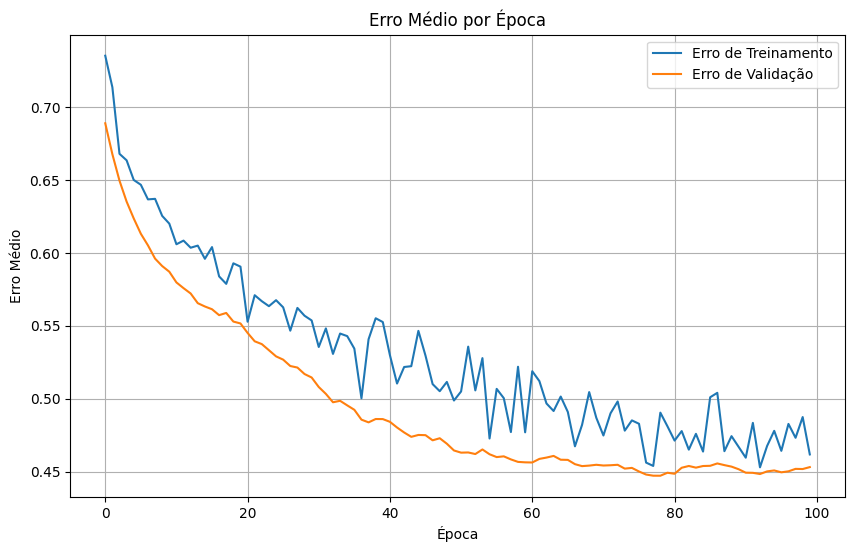

In [88]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_validation, y_validation))

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Erro de Treinamento')
plt.plot(history.history['val_loss'], label='Erro de Validação')
plt.title('Erro Médio por Época')
plt.xlabel('Época')
plt.ylabel('Erro Médio')
plt.legend()
plt.grid()
plt.show()

Mostramos então a matriz confução do treinamento:

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


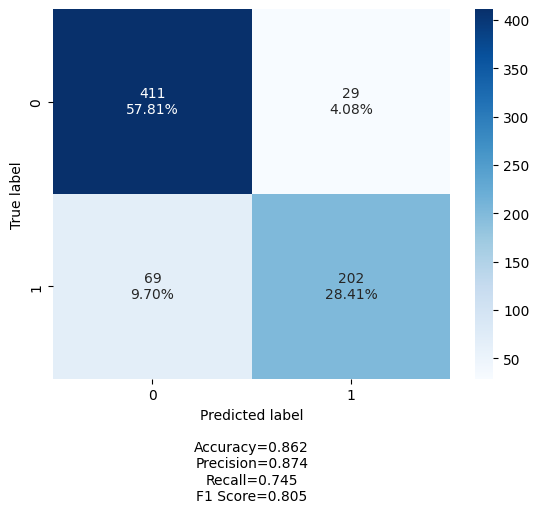

In [89]:
cf_matrix_train = confusion_matrix(y_train, model.predict(X_train) > 0.5)
cfm.make_confusion_matrix(cf_matrix_train)

E a matriz confusão do teste:

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


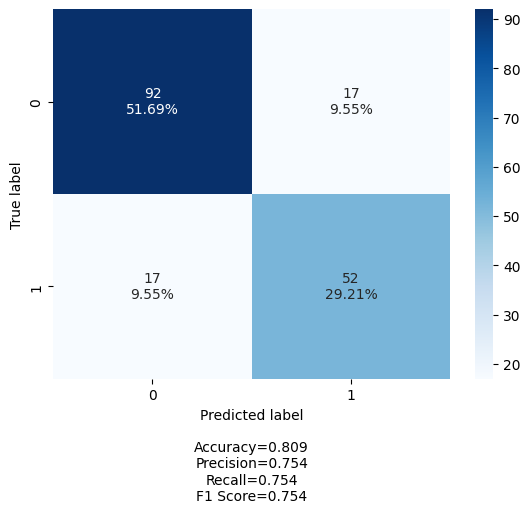

In [90]:

cf_matrix_test = confusion_matrix(y_test, model.predict(X_validation) > 0.5)
cfm.make_confusion_matrix(cf_matrix_test)

Agora criaremos os valores para testarmos no Kaggle:

In [99]:
test_ids = test['PassengerId']
submission_preds = model.predict(X_test_scaled) > 0.5
df = pd.DataFrame({'PassengerId': test_ids, 'Survived': submission_preds.flatten().astype(int)})
df.to_csv('submission.csv', index=False)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


Fontes:
- Notas de aula da matéria de Aprendizagem de Máquina do PPGI da UFPB em 2024.2
- [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
- [How to do the Titanic Kaggle Competition](https://www.youtube.com/watch?v=pUSi5xexT4Q)
- [Beginner Kaggle Data Science Project Walk-Through (Titanic)](https://www.youtube.com/watch?v=I3FBJdiExcg)
- [Resolva o Titanic Como um Campeão do Kaggle | Curso Completo](https://www.youtube.com/watch?v=1KguWZH4hXw)
- ABU-MOSTAFA, Yaser S.; MAGDON-ISMAIL, Malik; LIN, Hsuan-Tien. **Learning from data**. New York: AMLBook, 2012.